In [1]:
# math libraries
import numpy as np
# ml libraries
import tensorflow as tf
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# visualization
import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
# sys and helpers
import sys
import os
import glob
from tqdm import tqdm
print('Modules imported.')
# device check
from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())
# GPU check
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\CY\Anaconda3\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Modules imported.
Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4632494594823904881
]
No GPU found.


# Loading the data

In [2]:
def load_dataset(dataset, width, height, channels):
    if dataset == 'mnist':
        # load MNIST data
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
    if dataset == 'cifar10':
        # load CIFAR10 data
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()

        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # defining input dims
    img_rows = width
    img_cols = height
    channels = channels
    img_shape = [img_rows, img_cols, channels]
    return X_train, img_shape
# if MNIST ('mnist', 28, 28, 1) if CIFAR10 ('cifar10', 32, 32, 3)
dataset, shape = load_dataset('cifar10', 32, 32, 3)
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))

 90710016/170498071 [==============>...............] - ETA: 1:27:0 - ETA: 35:11  - ETA: 20:1 - ETA: 16:5 - ETA: 15:1 - ETA: 10:2 - ETA: 6:1 - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: 

## Helper functions for Capsule layers

In [3]:
# squash function of capsule layers, borrowed from Xifeng Guo's implementation of Keras CapsNet `https://github.com/XifengGuo/CapsNet-Keras`
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

## Defining the model

In [4]:
# discriminator structure
def build_discriminator():

    """
    This is the part my 'Capsule Layer as a Discriminator in Generative Adversarial Networks' paper focuses on,
    as it introduces a new structure to the discriminator of DCGAN by using Capsule Layers architecture from original
    'Dynamic Routing Between Capsules' paper by S. Sabour, N. Frosst and G. Hinton.
    
    Discriminator takes real/generated images and outputs its prediction.
    """
    # depending on dataset we define input shape for our network
    img = Input(shape=(shape[0], shape[1], shape[2]))
    # first typical convlayer outputs a 20x20x256 matrix
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    # original 'Dynamic Routing Between Capsules' paper does not include the batch norm layer after the first conv group
    x = BatchNormalization(momentum=0.8)(x)
    
    """
    NOTE: Capsule architecture starts from here.
    """
    #
    # primarycaps coming first
    #
    
    # filters 256 (n_vectors=8 * channels=32)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    
    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    
    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)

    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.
    
    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    x = Flatten()(x)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    
    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)

    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    pred = Dense(1, activation='sigmoid')(s_j)

    
    return Model(img, pred)

In [5]:
# build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 24, 24, 256)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 256)  1024        leaky_re_lu_1[0][0]              
______________________________________________________________________________________________

In [6]:
# generator structure
def build_generator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """

    noise_shape = (100,)
    x_noise = Input(shape=noise_shape)

    # we apply different kernel sizes in order to match the original image size
    
    if (shape[0] == 28 and shape[1] == 28):
        x = Dense(128 * 7 * 7, activation="relu")(x_noise)
        x = Reshape((7, 7, 128))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        gen_out = Activation("tanh")(x)
        
        return Model(x_noise, gen_out)

    if (shape[0] == 32 and shape[1] == 32):
        x = Dense(128 * 8 * 8, activation="relu")(x_noise)
        x = Reshape((8, 8, 128))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Conv2D(3, kernel_size=3, padding="same")(x)
        gen_out = Activation("tanh")(x)

        
        return Model(x_noise, gen_out)

In [7]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         

In [8]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)

In [9]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [10]:
# try to discriminate generated images
valid = discriminator(img)

In [11]:
# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
print('COMBINED:')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

COMBINED:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         1051779   
_________________________________________________________________
model_1 (Model)              (None, 1)                 8071233   
Total params: 9,123,012
Trainable params: 1,051,139
Non-trainable params: 8,071,873
_________________________________________________________________


## Training

In [12]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []

In [13]:
def train(dataset_title, epochs, batch_size=32, save_interval=50):

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # select a random half batch of images
            idx = np.random.randint(0, dataset.shape[0], half_batch)
            imgs = dataset[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # train the discriminator by feeding both real and fake (generated) images one by one
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))*0.9) # 0.9 for label smoothing
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # the generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * 32)

            # train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            D_L_REAL.append(d_loss_real)
            D_L_FAKE.append(d_loss_fake)
            D_L.append(d_loss)
            D_ACC.append(d_loss[1])
            G_L.append(g_loss)

            # if at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(dataset_title, epoch)

In [14]:
def save_imgs(dataset_title, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        # rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        # iterate in order to create a subplot
        for i in range(r):
            for j in range(c):
                if dataset_title == 'mnist':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
                elif dataset_title == 'cifar10':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                    axs[i,j].axis('off')
                    cnt += 1
                else:
                    print('Please indicate the image options.')
        
        if not os.path.exists('images_{0}'.format(dataset_title)):
            os.makedirs('images_{0}'.format(dataset_title))
        
        fig.savefig("images_{0}/{1}.png".format(dataset_title, epoch))
        plt.close()

In [15]:
history = train('cifar10', epochs=30, batch_size=32, save_interval=50)
#generator.save('mnist_model.h5')
generator.save('cifar10_model.h5')

C:\Users\CY\Anaconda3\envs\python3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.694122, acc.: 21.88%] [G loss: 0.694731]
1 [D loss: 0.692496, acc.: 28.12%] [G loss: 0.689439]
2 [D loss: 0.695210, acc.: 12.50%] [G loss: 0.688043]
3 [D loss: 0.693530, acc.: 18.75%] [G loss: 0.688326]
4 [D loss: 0.689303, acc.: 18.75%] [G loss: 0.683292]
5 [D loss: 0.704114, acc.: 12.50%] [G loss: 0.688243]
6 [D loss: 0.689532, acc.: 15.62%] [G loss: 0.689497]
7 [D loss: 0.684016, acc.: 18.75%] [G loss: 0.682354]
8 [D loss: 0.683216, acc.: 18.75%] [G loss: 0.705892]
9 [D loss: 0.667773, acc.: 31.25%] [G loss: 0.692142]
10 [D loss: 0.690226, acc.: 15.62%] [G loss: 0.703884]
11 [D loss: 0.672327, acc.: 18.75%] [G loss: 0.711753]
12 [D loss: 0.709813, acc.: 12.50%] [G loss: 0.705808]
13 [D loss: 0.686223, acc.: 3.12%] [G loss: 0.677907]
14 [D loss: 0.657414, acc.: 18.75%] [G loss: 0.706397]
15 [D loss: 0.677811, acc.: 9.38%] [G loss: 0.704926]
16 [D loss: 0.661148, acc.: 28.12%] [G loss: 0.686294]
17 [D loss: 0.687268, acc.: 25.00%] [G loss: 0.704515]
18 [D loss: 0.653348, 

## Visualizations

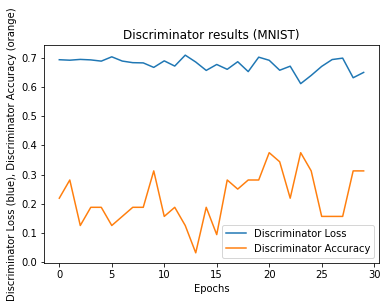

In [16]:
plt.plot(D_L)
plt.title('Discriminator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

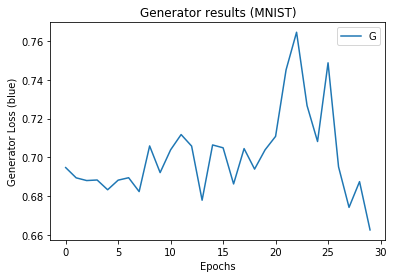

In [17]:
plt.plot(G_L)
plt.title('Generator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()

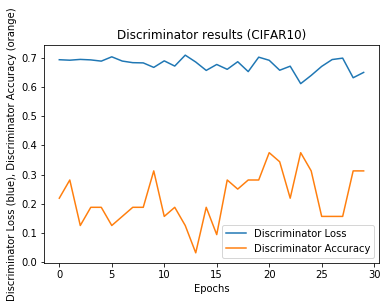

In [18]:
plt.plot(D_L)
plt.title('Discriminator results (CIFAR10)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

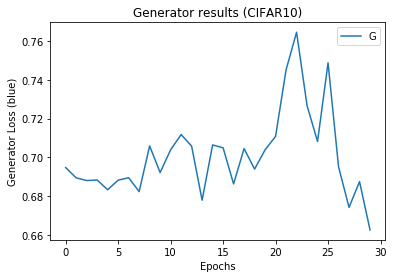

In [19]:
plt.plot(G_L)
plt.title('Generator results (CIFAR10)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()